# Using UP bank's API to pull transactional data for spending analysis.

In [1]:
#Importing necessary libraries. 
import pandas as pd
import numpy as np
import matplotlib as plt
import requests
%matplotlib inline

### Hitting UP bank's API using my authorization token. 

In [4]:
baseurl = "https://api.up.com.au/api/v1"
endpoint = "/transactions"
header = {"Authorization" : "Bearer up:yeah:KqHLbQfWLZPDeJIHDQpQUir3kCUpq8U8YMVGJeWW1K94UvHuQggTuhLQ1gbL3ILle33sA3DIrZ82grdIaK3BAWT2aQRyQaGoty8JzRWXOPSsMHGoWCVx8le59pwwKZRw"}

In [5]:
# obtaining transaction list, r from API.
r = requests.get(baseurl+endpoint, headers = header, params= 'page[size]=100').json()

In [11]:
#saving JSON
import json
with open("r.json", "w", encoding = "utf-8") as f:
          json.dump(r, f, ensure_ascii = False, indent = 4)

### Pulling out desired values from JSON

In [121]:
trans_description = r["data"][0]["attributes"]["description"]

In [122]:
amount = r["data"][0]["attributes"]["amount"]["value"]

In [123]:
category = r["data"][0]["relationships"]["category"]["data"]["id"]

In [124]:
date = r["data"][0]["attributes"]["createdAt"]
#converting string to datetime
date=pd.Timestamp(date)


### Writing a FOR loop to pull the data that I want from the JSON, printing result to check values

In [132]:
for transaction in r["data"]:
    if transaction["relationships"]["category"]["data"] != None:
    
        trans_description = transaction["attributes"]["description"]
        amount = transaction["attributes"]["amount"]["value"]
        category = transaction["relationships"]["category"]["data"]["id"]
        date = transaction["attributes"]["createdAt"]
        date = pd.Timestamp(date, tz = None, tzinfo = None)

        print(trans_description)
        print(amount)
        print(category)
        print(date)


Guzman y Gomez
-15.50
takeaway
2022-08-08 14:47:29+10:00
Woolworths Metro Carter St
-11.54
groceries
2022-08-07 19:04:16+10:00
EG
-124.56
fuel
2022-07-30 19:16:20+10:00
Kyo Sushi Bar
-75.21
takeaway
2022-07-28 20:47:43+10:00
Zambrero
-15.90
takeaway
2022-07-26 12:33:20+10:00
The Gozleme Co.
-13.00
restaurants-and-cafes
2022-07-26 12:28:41+10:00
Woolworths
-10.60
groceries
2022-07-26 12:27:02+10:00
Ampol
-60.17
fuel
2022-07-24 23:41:02+10:00
BP
-111.76
fuel
2022-07-24 18:08:00+10:00
Friday Flat Donut Hut
-5.50
takeaway
2022-07-24 17:06:34+10:00
The Local Pub
-38.00
restaurants-and-cafes
2022-07-24 14:32:43+10:00
Kosciuszko National Park
-58.00
holidays-and-travel
2022-07-23 09:47:52+10:00
BWS
-86.00
booze
2022-07-21 20:17:07+10:00
Guzman y Gomez
-25.00
takeaway
2022-07-21 19:57:33+10:00
UNIQLO
-50.05
clothing-and-accessories
2022-07-21 19:49:35+10:00
The Locker Room
-9.00
pubs-and-bars
2022-07-17 14:23:08+10:00
The Locker Room
-50.00
pubs-and-bars
2022-07-17 14:18:33+10:00
Woolworths
-1

### Writing a FOR loop to pull data into a DataFrame for analysis.

In [151]:
data = []
for transaction in r["data"]:
    if transaction["relationships"]["category"]["data"] != None:
    
        trans_description = transaction["attributes"]["description"]
        amount = transaction["attributes"]["amount"]["value"]
        category = transaction["relationships"]["category"]["data"]["id"]
        date = transaction["attributes"]["createdAt"]
        date = pd.Timestamp(date)
        data.append((trans_description, 
                    amount,
                    category,
                    date))
        
df = pd.DataFrame(data = data, columns = ["Description", "Amount", "Category", "Date"])

### Saving data into CSV

In [127]:
df.to_csv("upbank.csv")

### Cleaning and formatting data

In [152]:
# changing "Amount" datatype from string to float for numeric calculations
df["Amount"] = df["Amount"].astype(float)

In [153]:
# removing the timezone from the timestamp for better readability
df["Date"] = df["Date"].dt.tz_localize(None)

In [154]:
# making the Date the index
df = df.set_index("Date")

In [155]:
# titled the "category" for consistent formatting
df["Category"] = df["Category"].str.title()

### Working out how much was spent on eating out. 

In [160]:
mask1 = df["Category"] == "Takeaway"
mask2 = df["Category"] == "Restaurants-And-Cafes"

In [162]:
df_food = df[mask1 | mask2]

In [167]:
df_food["Amount"].sum()

-1668.3899999999999

### Analyzing how much was spent in each category

In [178]:
df["Category"].unique()

array(['Takeaway', 'Groceries', 'Fuel', 'Restaurants-And-Cafes',
       'Holidays-And-Travel', 'Booze', 'Clothing-And-Accessories',
       'Pubs-And-Bars', 'Parking', 'Public-Transport',
       'Health-And-Medical', 'Technology'], dtype=object)

In [222]:
#summing amount spent by category
amount_spent_by_category = df.groupby(["Category"]).sum()

In [223]:
### converting dollar amount spent to positive amount for better readability
amount_spent_by_category["Amount"] = amount_spent_by_category["Amount"] * -1
amount_spent_by_category

,Amount
Category,
Booze,190.80
Clothing-And-Accessories,50.05
Fuel,433.22
Groceries,697.98
Health-And-Medical,163.90
Holidays-And-Travel,58.00
Parking,19.38
Public-Transport,57.92
Pubs-And-Bars,72.00


### Visualizing the data 

In [212]:
# decided to go with this particular style
plt.style.use("fivethirtyeight")

<AxesSubplot:ylabel='Category'>

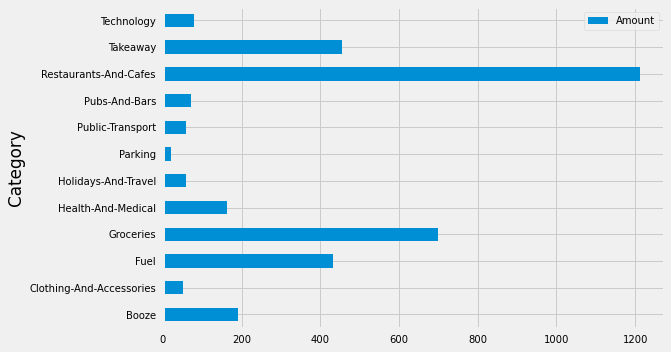

In [213]:
# horizontal bars made the most sense for visualisation for readability.
amount_spent_by_category.plot(y ="Amount", kind = "barh")

In [229]:
avg_amount_spent_per_transaction = df.groupby(["Category"]).mean()

In [234]:
avg_amount_spent_per_transaction["Amount"] = avg_amount_spent_per_transaction["Amount"] *-1
avg_amount_spent_per_transaction

,Amount
Category,
Booze,95.400000
Clothing-And-Accessories,50.050000
Fuel,108.305000
Groceries,38.776667
Health-And-Medical,81.950000
Holidays-And-Travel,58.000000
Parking,3.876000
Public-Transport,6.435556
Pubs-And-Bars,24.000000


<AxesSubplot:ylabel='Category'>

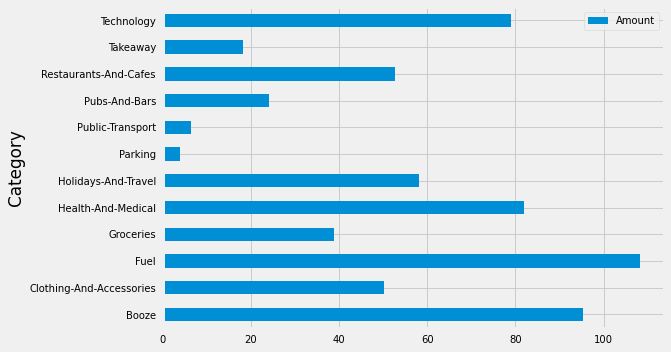

In [235]:
avg_amount_spent_per_transaction.plot(y = "Amount", kind = "barh")

This has been a good look into my spending over the past few months. It is clear that a large portion of my spending goes towards restaurants and the like. It is also important to note that expenses such as bills and subscriptions are paid out of another bank account. The UP bank account is predominantly POS focused transactions. In the future I hope to centralize my spending so deeper analysis can be performed.

Regardless it has been enjoyable playing around with APIs and JSONs, something which I had not done before. 

Thanks for reading!